# Tutorial 3

In this tutorial we examine a reciprocity property of the elastic sea level equation and consider the calculation of sensitivity kernels for sea level measurements. These results are based on the paper Al-Attar *et al.* (2024) where the following reciprocity theorem is established:
$$
\int_{\partial M} \zeta^{\dagger} \Delta SL \, \mathrm{d} S = \int_{\partial M} \zeta \Delta SL^{\dagger} \, \mathrm{d} S, 
$$
where $(\zeta,\Delta SL)$ and $(\zeta^{\dagger}, \Delta SL^{\dagger})$ are any two pairs of direct loads and corresponding sea level changes. 

### Checking the reciprocity theorem

As a first step, we will generate two such pairs of direct loads and sea level changes and verify that the reciprocity theorem holds. Doing this consitutes a check on the numerical implementation of the sea level equation within this library. 

In [33]:
# Import necessary modules for this notebook. 
import numpy as np
import matplotlib.pyplot as plt
from pyslfp import FingerPrint

# Set up the FingerPrint instance.
fingerprint = FingerPrint()

# Set the initial sea level and ice thickness.
fingerprint.set_state_from_ice_ng()

# Generate the first pair by melting all northern hemisphere ice.
direct_load_1 = fingerprint.northern_hemisphere_load()
sea_level_change_1, _, _, _ = fingerprint(direct_load=direct_load_1)

# Generate the second pair by melting all southern hemisphere ice.
direct_load_2 = fingerprint.southern_hemisphere_load()
sea_level_change_2, _, _, _ = fingerprint(direct_load=direct_load_2)

# Compute the two integrals
lhs = fingerprint.integrate(direct_load_2 * sea_level_change_1)
rhs = fingerprint.integrate(direct_load_1 * sea_level_change_2)

# Print the values for comparison
print(f'lhs value is {lhs}')
print(f'rhs value is {rhs}')

# Work out the relative difference. This should be of the same order of
# rtol=1e-6 used in solving the sea level equation. 
print(f'relative difference is is {np.abs(rhs-lhs) / np.abs(rhs)}')




lhs value is -1.8943880447165737e+20
rhs value is -1.894390331315756e+20
relative difference is is 1.2070369789259607e-06


### Checking again using different loads

To verify that the above result isn't a fluke, we can repeat the above test using disk loads that can have arbitrary locations and sizes.

In [34]:
# Set up the first pair using a disk load
angular_radius_1 = 10
centre_lat_1 = 10
centre_lon_1 = 50
amplitude_1 = 10
direct_load_1 = fingerprint.disk_load(angular_radius_1, centre_lat_1, centre_lon_1, amplitude_1)
sea_level_change_1, _, _, _ = fingerprint(direct_load=direct_load_1)

# Generate the second pair by melting all southern hemisphere ice.
angular_radius_2 = 30
centre_lat_2 = -50
centre_lon_2 = -40
amplitude_2 = -4
direct_load_2 = fingerprint.disk_load(angular_radius_2, centre_lat_2, centre_lon_2, amplitude_2)
sea_level_change_2, _, _, _ = fingerprint(direct_load=direct_load_2)

# Compute the two integrals
lhs = fingerprint.integrate(direct_load_2 * sea_level_change_1)
rhs = fingerprint.integrate(direct_load_1 * sea_level_change_2)

# Print the values for comparison
print(f'lhs value is {lhs}')
print(f'rhs value is {rhs}')

# Work out the relative difference. This should be of the same order of
# rtol=1e-6 used in solving the sea level equation. 
print(f'relative difference is is {np.abs(rhs-lhs) / np.abs(rhs)}')


lhs value is 16455095977.91695
rhs value is 16455104024.896788
relative difference is is 4.8902637292614e-07


### Sea level sensitivity kernels

If, within the reciprocity theorem, we take $\zeta^{\dagger} = \delta_{\mathbf{x}_{0}}$, with $\delta_{\mathbf{x}_{0}}$ the delta function based at $\mathbf{x}_{0}$, 
we see that
$$
\Delta SL(\mathbf{x}_{0}) = \int_{\partial M} \zeta \Delta SL^{\dagger} \,\mathrm{d} S. 
$$
This shows that the sea level change at the observation point, $\mathbf{x}_{0}$, is obtained by integrating the direct load against the function, $\Delta SL^{dagger}$, 
which is the fingerprint corresponding to a point load at the observation point. 

If we specialise to the case of an ice load, then $\zeta = \rho_{i}(1-C) \Delta I$, and hence we have 
$$
\Delta SL(\mathbf{x}_{0}) = \int_{\partial M} K \Delta I \,\mathrm{d} S, 
$$
where the sensitivity kernel, $K$, is given by
$$
K = \rho_{i}(1-C) \Delta SL^{\dagger}.
$$

These ideas are implemented within the following code. 

sea level change at the observation point is 2.837853796988215m
Sea level change at observation point using reciprocity 2.8378649063831562m
Sea level change at observation point using sensitivity kernel 2.837864906383157m


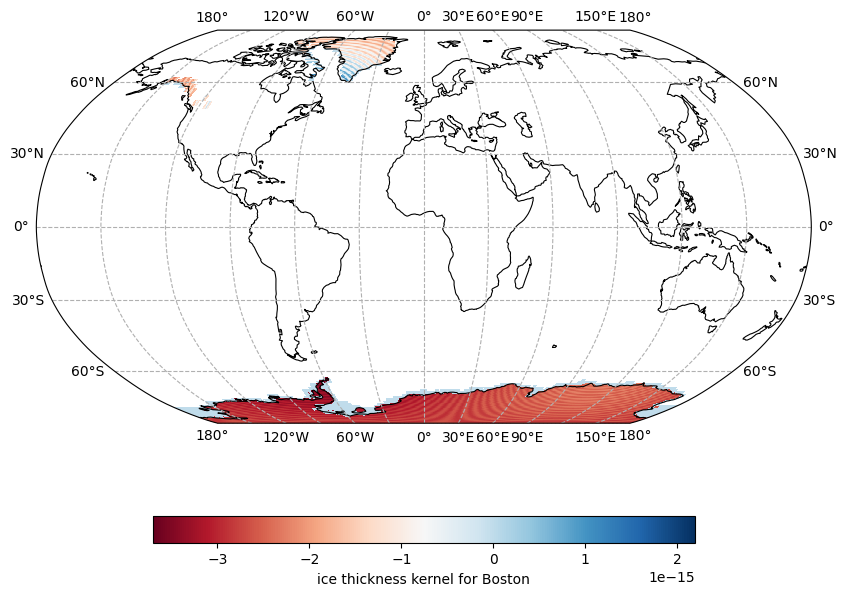

In [35]:
# Set the observation point to Boston, MA. 
lat = 42.3555
lon = -71.0565

# Generate data from an ice load. 
ice_thickness_change = -1* fingerprint.northern_hemisphere_projection(0) * fingerprint.ice_thickness
direct_load = fingerprint.direct_load_from_ice_thickness_change(ice_thickness_change)
sea_level_change, _, _, _ = fingerprint(direct_load=direct_load, rtol=1e-9)

# Evaluate the sea level change at the observation point
sea_level_change_at_location = fingerprint.point_evaulation(sea_level_change, lat, lon)
print(f'sea level change at the observation point is {sea_level_change_at_location}m')

# Set up the point load and compute the sensitivity kernel. 
point_load = fingerprint.point_load(lat, lon)
adjoint_sea_level_change,_,_,_ = fingerprint(direct_load=point_load, rtol=1e-9)

# Integrate the adjoint sea level change against the direct load:
print(f'Sea level change at observation point using reciprocity {fingerprint.integrate(adjoint_sea_level_change * direct_load)}m')

# Form the sensitivity kernel wrt ice thickness change
kernel = fingerprint.ice_density * fingerprint.one_minus_ocean_function * adjoint_sea_level_change
print(f'Sea level change at observation point using sensitivity kernel {fingerprint.integrate(kernel * ice_thickness_change)}m')

# Make a plot of the sensitivity kernel, projecting values onto the ice sheets. 
fig, ax, im = fingerprint.plot(kernel, ice_projection=True)
fig.colorbar(im, ax=ax, orientation="horizontal", shrink=0.7, label="ice thickness kernel for Boston")

plt.show()



From the above results, we see that the sensitivity kernel does a good job of predicting the sea level change at the observation point. The agreement is not, however, perfect, while the resulting kernel has odd looking osscilations. This is not a limitation of the theory but of the implementation of singular point loads within the code. The accuracy of the predictions can be improved by using a higher truncation degree and by requiring a more stringent tolerance in solving the sea level equation (note in the above, ```rtol```
was lowered to ```1e-9``` from the default of ```1e-6```).

The oscillations of the kernel are, however, unavoidable within a formalism that regards the sensitivity kernel as an element of the same space as the ice thickness change. To deal with this issue properly a more careful mathematical treatment is necessary, recognising that the kernel is a generalised function. This will be discussed in a later tutorial. For the moment, however, we take a pragmatic approach of smoothing the delta function over a certain length scale. This removes the oscillations from the sensitivity kernel and hence allows for a meaningful physical interpretation. 

average of the sea level about the observation point 2.8334281398858066m
integral of sensitivity kernel again ice thickness change 2.83342852678521m


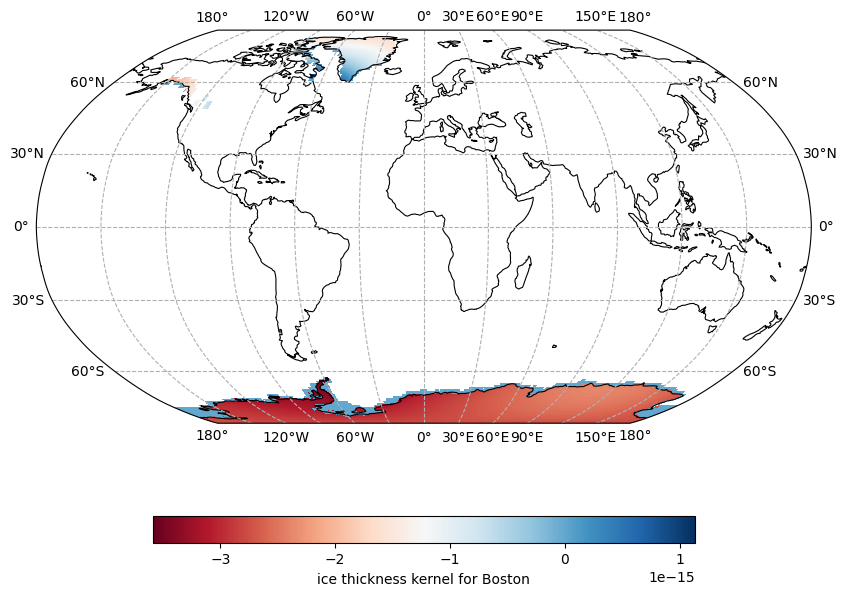

In [36]:
# Set up the point load and compute the sensitivity kernel now using smoothing over 2 degrees.
point_load = fingerprint.point_load(lat, lon, smoothing_angle=2)
adjoint_sea_level_change,_,_,_ = fingerprint(direct_load=point_load, rtol=1e-9)

# Form the sensitivity kernel wrt ice thickness change
kernel = fingerprint.ice_density * fingerprint.one_minus_ocean_function * adjoint_sea_level_change


print(f'average of the sea level about the observation point {fingerprint.integrate(point_load*sea_level_change)}m')
print(f'integral of sensitivity kernel again ice thickness change {fingerprint.integrate(kernel*ice_thickness_change)}m')

# Make a plot of the sensitivity kernel, projecting values onto the ice sheets. 
fig, ax, im = fingerprint.plot(kernel, ice_projection=True)
fig.colorbar(im, ax=ax, orientation="horizontal", shrink=0.7, label="ice thickness kernel for Boston")

plt.show()